# Imports

In [77]:
import math
import datetime
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Load data

In [2]:
data_path = '../../01_Data/'

In [3]:
items = pd.read_csv('{}items.csv'.format(data_path), sep='|')
items.head()

,itemID,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice
0,1,0,1,4.38,1,1,1,8.84
1,2,0,2,3.00,1,2,1,16.92
2,3,0,3,5.00,1,3,1,15.89
3,4,0,2,4.44,1,2,1,40.17
4,5,0,2,2.33,1,1,1,17.04


In [4]:
infos = pd.read_csv('{}infos.csv'.format(data_path), sep='|')
infos.head()

,itemID,simulationPrice,promotion
0,1,3.43,NaN
1,2,9.15,NaN
2,3,14.04,NaN
3,4,14.10,NaN
4,5,7.48,NaN


In [5]:
orders = pd.read_csv('{}orders_split/orders0206_train.csv'.format(data_path), sep='|')
orders.head()

,time,transactID,itemID,order,salesPrice
0,2018-01-01 00:01:56,2278968,450,1,17.42
1,2018-01-01 00:01:56,2278968,83,1,5.19
2,2018-01-01 00:07:11,2255797,7851,2,20.47
3,2018-01-01 00:09:24,2278968,450,1,17.42
4,2018-01-01 00:09:24,2278968,83,1,5.19


In [6]:
train = pd.merge(left=pd.merge(left=items, right=infos, on='itemID'), right=orders, on='itemID').set_index('time', drop=False)
train.head()

,itemID,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice,simulationPrice,promotion,time,transactID,order,salesPrice
time,,,,,,,,,,,,,,
2018-01-23 16:46:03,1,0,1,4.38,1,1,1,8.84,3.43,NaN,2018-01-23 16:46:03,2261889,1,3.11
2018-01-25 13:32:34,1,0,1,4.38,1,1,1,8.84,3.43,NaN,2018-01-25 13:32:34,2263523,1,3.11
2018-01-29 11:06:00,1,0,1,4.38,1,1,1,8.84,3.43,NaN,2018-01-29 11:06:00,162329,1,3.11
2018-01-29 11:06:01,1,0,1,4.38,1,1,1,8.84,3.43,NaN,2018-01-29 11:06:01,162330,1,3.11
2018-01-29 11:06:01,1,0,1,4.38,1,1,1,8.84,3.43,NaN,2018-01-29 11:06:01,162331,1,3.11


In [7]:
for cat_feature in 'brand manufacturer category1 category2 category3'.split():
    print('Number of unique {}s: {}'.format(cat_feature, train[cat_feature].nunique()))

Number of unique brands: 243
Number of unique manufacturers: 241
Number of unique category1s: 8
Number of unique category2s: 51
Number of unique category3s: 8


In [8]:
train['customerRating recommendedRetailPrice simulationPrice salesPrice'.split()].describe()

,customerRating,recommendedRetailPrice,simulationPrice,salesPrice
count,1.727364e+06,1.727364e+06,1.727364e+06,1.727364e+06
mean,2.412171e+00,3.260923e+01,3.453256e+01,3.792400e+01
std,2.268372e+00,9.975353e+01,1.310002e+02,1.323532e+02
min,0.000000e+00,2.460000e+00,3.800000e-01,0.000000e+00
25%,0.000000e+00,1.083000e+01,6.100000e+00,7.430000e+00
50%,3.000000e+00,1.629000e+01,1.481000e+01,1.745000e+01
75%,5.000000e+00,2.626000e+01,3.096000e+01,3.499000e+01
max,5.000000e+00,6.955000e+03,9.055070e+03,9.387020e+03


# Extract additional features

In [9]:
train['time'] = train.apply(lambda row: datetime.datetime.strptime(row['time'],"%Y-%m-%d %H:%M:%S"), axis=1)

# Month of the year
train['month'] = train.apply(lambda row: row['time'].month, axis=1)

# Day of the month
train['day'] = train.apply(lambda row: row['time'].day, axis=1)

# Weekday: Starts with 0 = Monday, 6 = Sunday
train['weekday'] = train.apply(lambda row: row['time'].weekday(), axis=1)

# Just the date, no time
train['date'] = train.apply(lambda row: datetime.datetime(year=2018, month=row['month'], day=row['day']), axis=1)

# Hour of the day
train['hour'] = train.apply(lambda row: row['time'].hour, axis=1)

In [22]:
# Calendar week
train['calendar_week'] = train.apply(lambda row: row['time'].isocalendar()[1], axis=1)

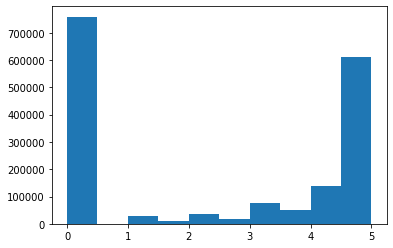

In [10]:
plt.hist(train['customerRating'])
plt.show()

# Exploration

In [17]:
def plot(x, y, agg):
    df_daily=train.groupby(x).agg([agg]).reset_index()
    if not isinstance(y, list):
        y = [y]
    for y_ in y:
            df_daily.plot(x=x, y=y_,kind="bar", title="{} of {} by {}".format(agg, y_, x))
    plt.show()

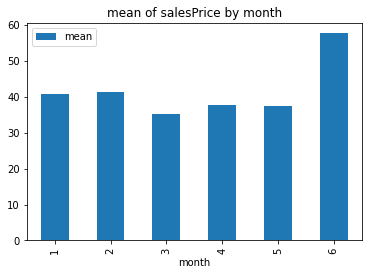

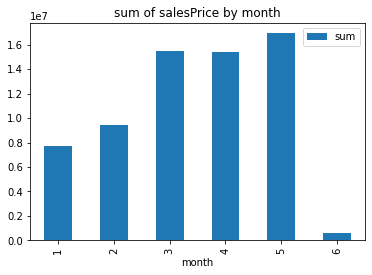

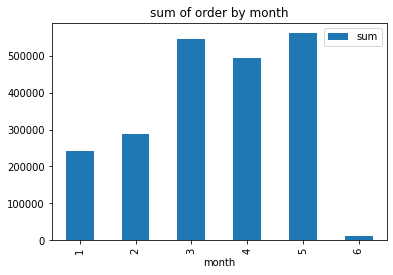

In [18]:
plot('month', ['salesPrice'], 'mean')
plot('month', ['salesPrice', 'order'], 'sum')

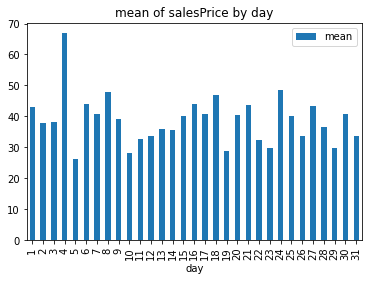

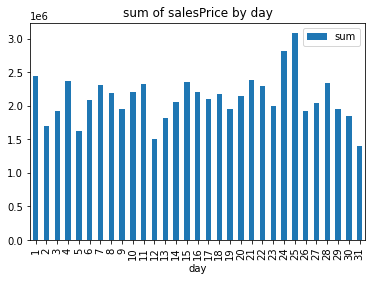

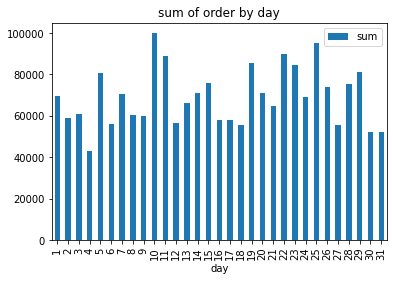

In [19]:
plot('day', ['salesPrice'], 'mean')
plot('day', ['salesPrice', 'order'], 'sum')

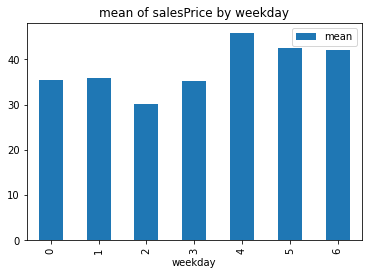

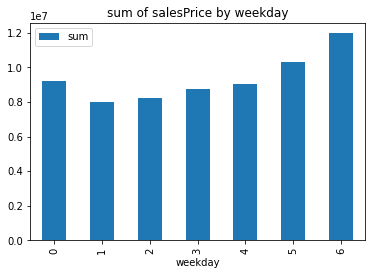

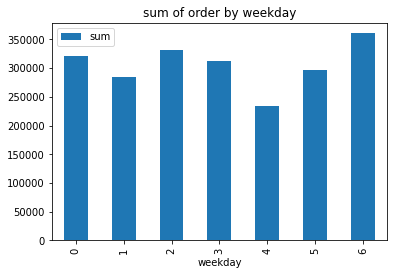

In [20]:
plot('weekday', ['salesPrice'], 'mean')
plot('weekday', ['salesPrice', 'order'], 'sum')

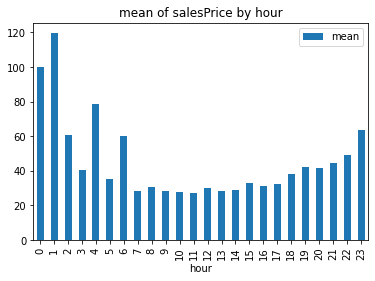

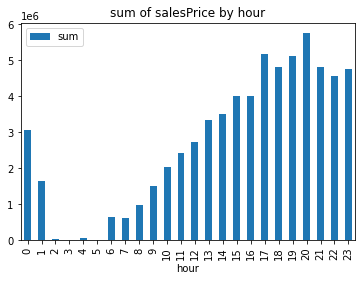

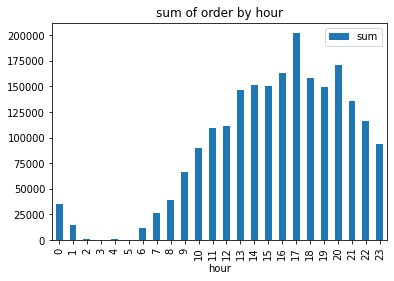

In [21]:
plot('hour', ['salesPrice'], 'mean')
plot('hour', ['salesPrice', 'order'], 'sum')

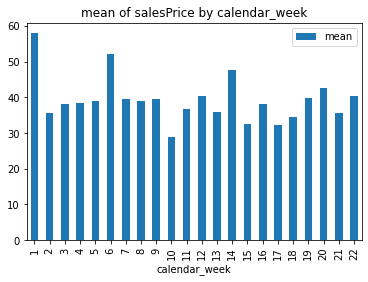

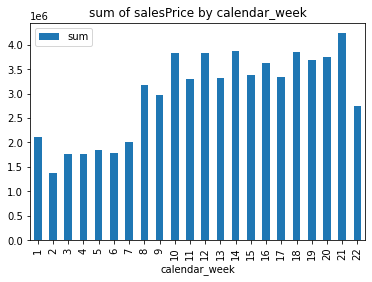

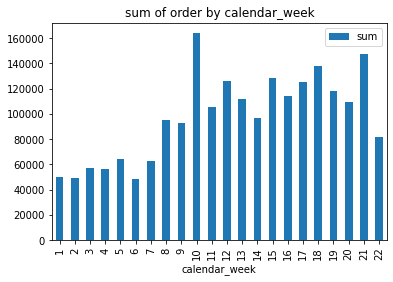

In [24]:
plot('calendar_week', ['salesPrice'], 'mean')
plot('calendar_week', ['salesPrice', 'order'], 'sum')

In [26]:
train['priceDifference'] = train['salesPrice'] - train['recommendedRetailPrice']

In [37]:
train['relPriceDifference'] = train['priceDifference'] / train['recommendedRetailPrice']

In [65]:
def hasPromotion(row):
    if isinstance(row['promotion'], float):
        return False
    else:
        promotion_dates = row['promotion'].split(',')
        promotion_dates = [datetime.datetime.strptime(date,"%Y-%m-%d") for date in promotion_dates]
        if row['date'] in promotion_dates:
            return True
        else:
            False

In [67]:
train['hasPromotion'] = train.apply(lambda row: hasPromotion(row), axis=1)

In [75]:
train.loc[train['itemID'] == 7761]['salesPrice'].unique()

array([2.48, 3.38])

In [74]:
train.loc[train['itemID'] == 7761]['recommendedRetailPrice'].unique()

array([9.15])

In [73]:
train.loc[train['itemID'] == 7761]['simulationPrice'].unique()

array([2.48])

In [78]:
train.loc[train['itemID'] == 7761]

,itemID,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice,simulationPrice,promotion,time,transactID,order,salesPrice,month,day,weekday,date,hour,calendar_week,priceDifference,relPriceDifference,hasPromotion
time,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01 11:15:28,7761,112,128,4.58,4,40,7,9.15,2.48,NaN,2018-01-01 11:15:28,2293694,1,2.48,1,1,0,2018-01-01,11,1,-6.67,-0.728962,False
2018-01-02 05:42:07,7761,112,128,4.58,4,40,7,9.15,2.48,NaN,2018-01-02 05:42:07,2277009,2,2.48,1,2,1,2018-01-02,5,1,-6.67,-0.728962,False
2018-01-02 13:26:04,7761,112,128,4.58,4,40,7,9.15,2.48,NaN,2018-01-02 13:26:04,2264250,2,2.48,1,2,1,2018-01-02,13,1,-6.67,-0.728962,False
2018-01-02 18:20:15,7761,112,128,4.58,4,40,7,9.15,2.48,NaN,2018-01-02 18:20:15,2261292,3,2.48,1,2,1,2018-01-02,18,1,-6.67,-0.728962,False
2018-01-02 19:13:13,7761,112,128,4.58,4,40,7,9.15,2.48,NaN,2018-01-02 19:13:13,2279484,2,2.48,1,2,1,2018-01-02,19,1,-6.67,-0.728962,False
2018-01-02 23:05:42,7761,112,128,4.58,4,40,7,9.15,2.48,NaN,2018-01-02 23:05:42,12636,1,2.48,1,2,1,2018-01-02,23,1,-6.67,-0.728962,False
2018-01-03 09:58:38,7761,112,128,4.58,4,40,7,9.15,2.48,NaN,2018-01-03 09:58:38,2286797,1,2.48,1,3,2,2018-01-03,9,1,-6.67,-0.728962,False
2018-01-03 12:46:23,7761,112,128,4.58,4,40,7,9.15,2.48,NaN,2018-01-03 12:46:23,2277018,1,2.48,1,3,2,2018-01-03,12,1,-6.67,-0.728962,False
2018-01-04 11:13:18,7761,112,128,4.58,4,40,7,9.15,2.48,NaN,2018-01-04 11:13:18,2285085,1,2.48,1,4,3,2018-01-04,11,1,-6.67,-0.728962,False


In [80]:
train.loc[(train['itemID'] == 7761) & (train['salesPrice'] == 3.38)]

,itemID,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice,simulationPrice,promotion,time,transactID,order,salesPrice,month,day,weekday,date,hour,calendar_week,priceDifference,relPriceDifference,hasPromotion
time,,,,,,,,,,,,,,,,,,,,,,,
2018-04-04 10:01:35,7761,112,128,4.58,4,40,7,9.15,2.48,NaN,2018-04-04 10:01:35,2293931,1,3.38,4,4,2,2018-04-04,10,14,-5.77,-0.630601,False


In [69]:
list(train['promotion'].unique())

[nan,
 '2018-07-13',
 '2018-07-01,2018-07-02,2018-07-13',
 '2018-07-05,2018-07-11',
 '2018-07-01',
 '2018-07-04',
 '2018-07-08',
 '2018-07-05',
 '2018-07-09',
 '2018-06-30',
 '2018-07-11',
 '2018-07-06',
 '2018-07-08,2018-07-11',
 '2018-06-30,2018-07-13',
 '2018-06-30,2018-07-01,2018-07-11',
 '2018-07-08,2018-07-13',
 '2018-07-06,2018-07-13',
 '2018-07-06,2018-07-10',
 '2018-07-10',
 '2018-07-08,2018-07-10',
 '2018-06-30,2018-07-04',
 '2018-07-01,2018-07-10',
 '2018-07-02',
 '2018-06-30,2018-07-01',
 '2018-07-04,2018-07-05,2018-07-06',
 '2018-07-04,2018-07-05',
 '2018-07-03',
 '2018-07-03,2018-07-05',
 '2018-07-04,2018-07-09',
 '2018-07-04,2018-07-06',
 '2018-07-02,2018-07-04',
 '2018-07-12',
 '2018-07-03,2018-07-04',
 '2018-07-02,2018-07-03,2018-07-04',
 '2018-07-02,2018-07-03',
 '2018-07-01,2018-07-06',
 '2018-07-01,2018-07-08',
 '2018-07-02,2018-07-04,2018-07-06',
 '2018-07-02,2018-07-08',
 '2018-07-01,2018-07-04',
 '2018-07-02,2018-07-04,2018-07-08',
 '2018-07-02,2018-07-12',
 '201

In [85]:
df_daily = train.loc[train['itemID'] == 7761].groupby('date').agg(['sum']).reset_index()

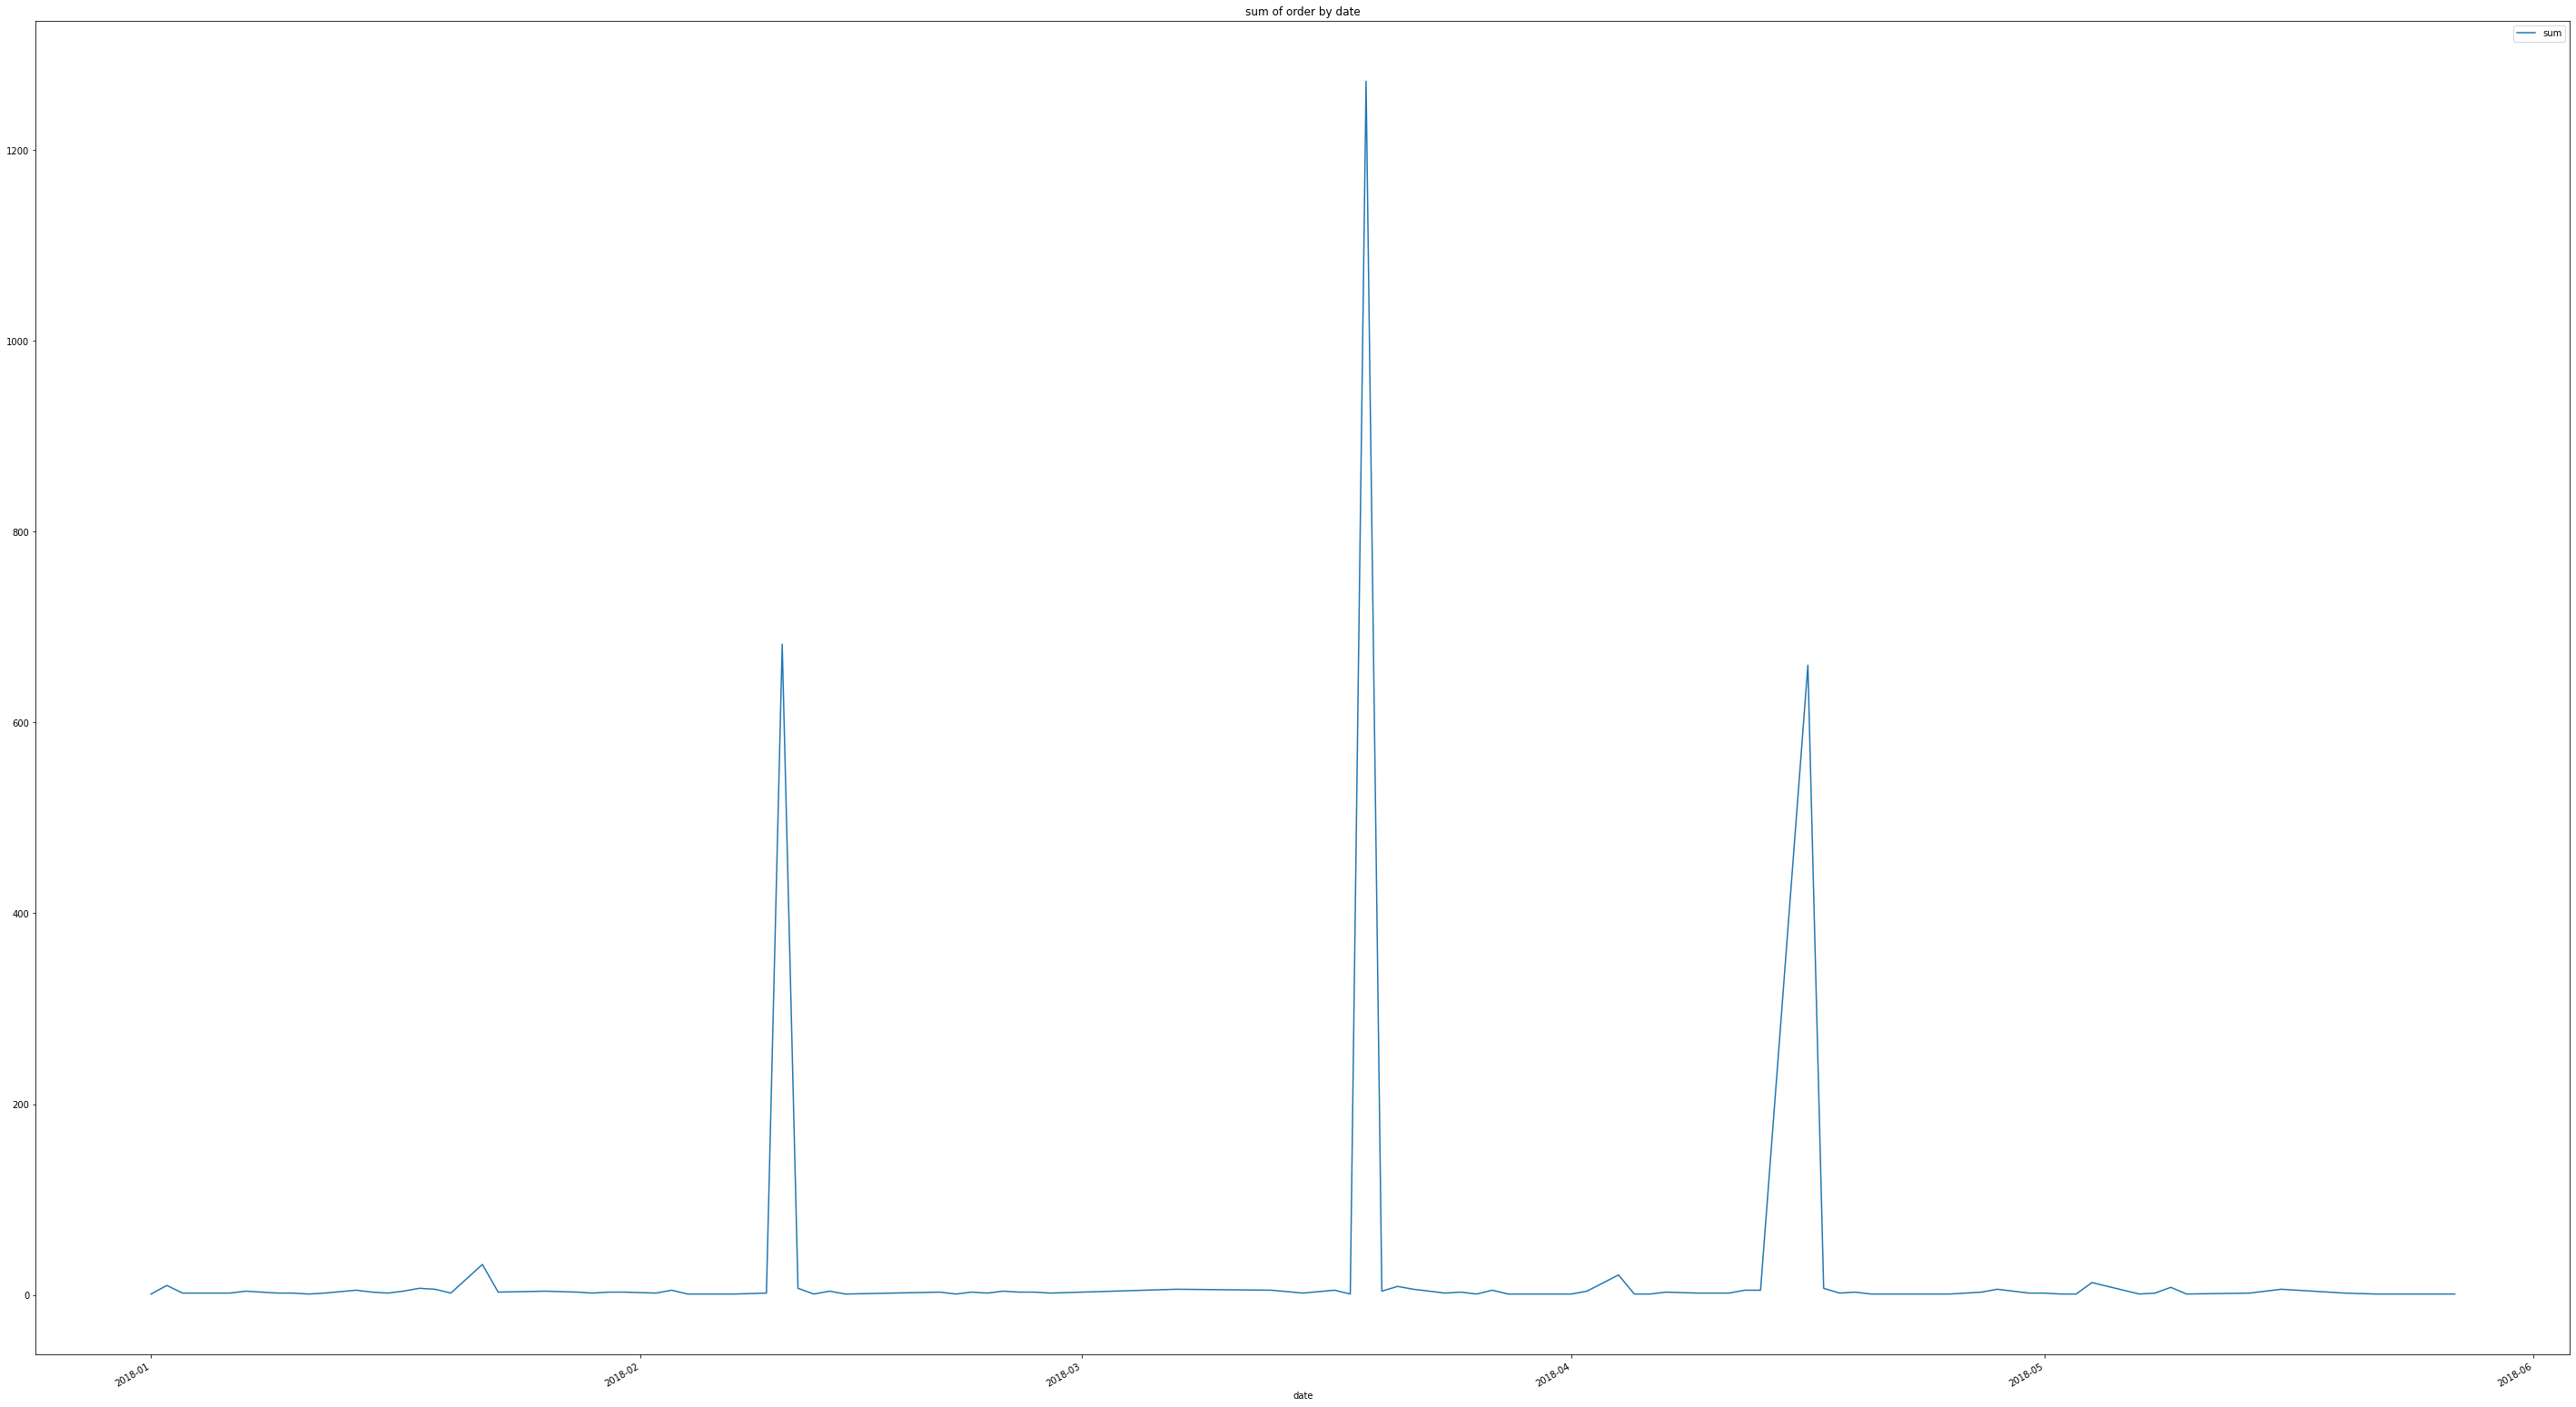

In [87]:
df_daily.plot(x='date', y='order',kind="line", title="{} of {} by {}".format('sum', 'order', 'date'), figsize=(50,30))